In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm

from mypackage import *

# Generating isotropic gaussian random fields on the sphere

__Plan :__

1. A lat/lon grid is defined
2. We construct the background correlation matrix $\mathbf{B}$ according to an isotropic gaussian correlation model
$$
\mathbf{B}(x,y) = \exp \left(-\frac{d(x,y)^2}{2 l_h^2} \right)
$$

where $d(x,y) = \arccos(x\cdot y) $ is the great circle distance.

3. We generate a random isotropic field $\zeta$ according to
$$
\zeta = \mathbf{B}^{1/2} \varepsilon
$$

where $\mathbf{B}^{1/2}$ is the matrix square root of $\mathbf{B}$ and $\varepsilon$ is obtained from a standard gaussian distribution.

4. We generate an ensemble of isotropic GRF $\{ \zeta_k \}_k $  and verify that the diagnosed errors statistics are correct. That is :
    - $\overline{\zeta_k} = 0 $ 
    - $\sigma = \sqrt{\overline{\zeta_k^2}} = 1$
    - The anisotropic tensor (in the correlation sense, not the geometry of the sphere) $\mathbf{s} = l_h^2 \mathbf{I}_2$.
    
    
    
__Computing the anisotropic tensor on the sphere__ 

The anisotropic tensor (correlation sense) is related to the metric tensor (correlation sense) according to $\mathbf{s} = \mathbf{g}^{-1}$ (the matrix inverse). The metric tensor $\mathbf{g}$  (correlation sense) is defined by :
$$
g = \mathbb{E} \left[ \left( \nabla \tilde{\zeta} \right) \left( \nabla \tilde{\zeta} \right)^T \right],
$$

with $\nabla = \left(\frac{\partial}{\partial \theta}, \frac{1}{\cos \theta}\frac{\partial}{\partial \varphi} \right)$ for the sphere $\mathbb{S}^2$, and $\tilde{\zeta} = \zeta / \sigma $ the normalized error.

__Limitations__ :
Requires the computation of $\mathbf{B}^{1/2}$ which becomes very costly when the grid definition augments.

## 1. defining the lat/lon grid :

In [2]:
n = 55
grid = LatLonGrid(n)

## 2. B construction 

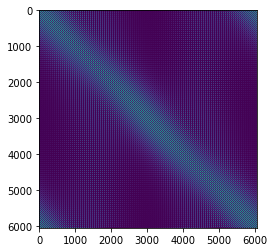

In [3]:
OM_r = grid.OM.reshape(np.prod(grid.OM.shape[:2]),-1)

vdots = OM_r @ OM_r.T
vdots[vdots>1] = 1
vdots[vdots<-1] = -1
gcd = np.arccos(vdots)  #great circle distance

lh = 0.4

B = np.exp(-gcd**2/lh**2/2)

plt.imshow(B);

## 3. Generation of an isotropic GRF (gaussian random field)

In [4]:
from scipy.linalg import sqrtm
sqrt_B = sqrtm(B)  # may take a while. dont try with n > 60, too long

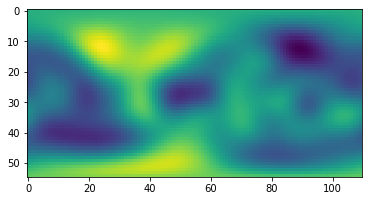

In [5]:
zeta = np.random.normal(0,1,(grid.m*grid.n))
grf = sqrt_B @ zeta
grf = np.real(grf.reshape((grid.m,grid.n)))
plt.imshow(grf.T);

## 4. Sanity check

With verify that the error statistics match what has been set.

In [6]:
def samples_generator(N):
    samps = np.random.normal(0,1,(grid.m*grid.n,N))
    return np.real((sqrt_B @ samps).T).reshape(N,grid.m,grid.n)



N = 6400*4
grfs = samples_generator(N)
mean, std, aspect_tensor = grid.ensemble_diagnosis(grfs)

/home/perrota/Documents/spherical-advection/mypackage/tools/LatLonGrid.py:145: RuntimeWarning: divide by zero encountered in true_divide
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],
/home/perrota/Documents/spherical-advection/mypackage/tools/LatLonGrid.py:145: RuntimeWarning: invalid value encountered in multiply
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],


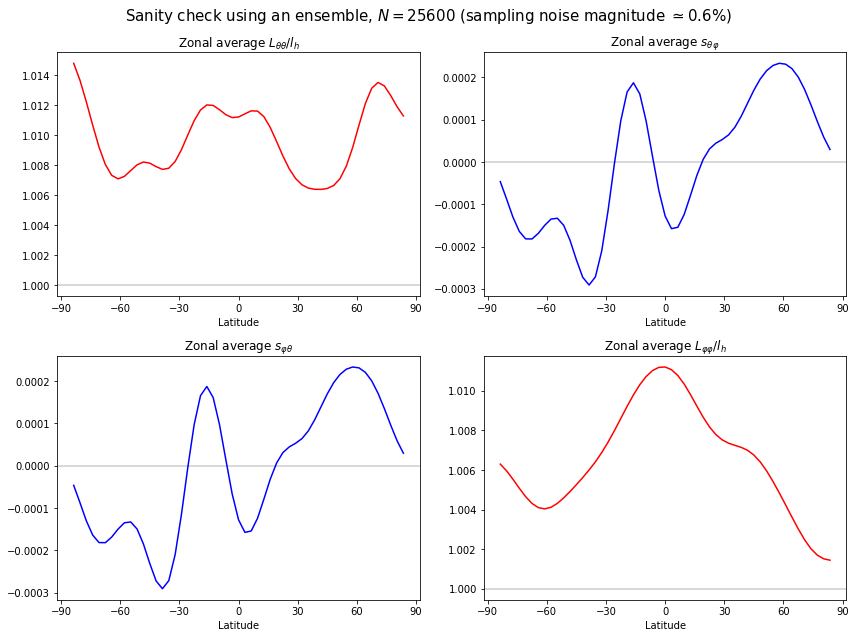

In [7]:
chars = [r'$L_{\theta\theta}/l_h$',r'$s_{\theta\varphi}$',r'$s_{\varphi\theta}$',r'$L_{\varphi\varphi}/l_h$']

fig, ax = plt.subplots(2,2,figsize=(12,9))

fig.suptitle(fr"Sanity check using an ensemble, $N=${N} (sampling noise magnitude $\simeq${100/N**.5:.1f}%)"
             ,fontsize=15)
for i in range(2):
    for j in range(2):
        div_by = lh*(i==j) + 1*(i!=j) 
        power = 0.5*(i==j) + 1*(i!=j)
        title = chars[i*2+j]
        ax[i,j].set_title("Zonal average "+title)
        c = 'r' if i==j else 'b'
        ax[i,j].plot(grid.theta[1:-1]/(np.pi/2)*90,aspect_tensor[i,j].T.mean(axis=1)**power/div_by,c=c)
        ax[i,j].set_xticks([-90,-60,-30,0,30,60,90])
        ax[i,j].set_xlabel("Latitude")
        ax[i,j].axhline(1*(i==j),c='k',alpha=0.2)
fig.tight_layout();

- The samples generated seems to be effectively isotropic.
- However the length-scales diagnosed are slightly above what has been prescribed. It may be due to numerical error ? 
- For $L_{\varphi \varphi}$, the length-scales agree with $L_{\theta\theta}$ at the equator but diminish towards the poles. I think it may bue to the augmentation of the resolution around the poles.

## 5. For fun : spherical plot of a GRF

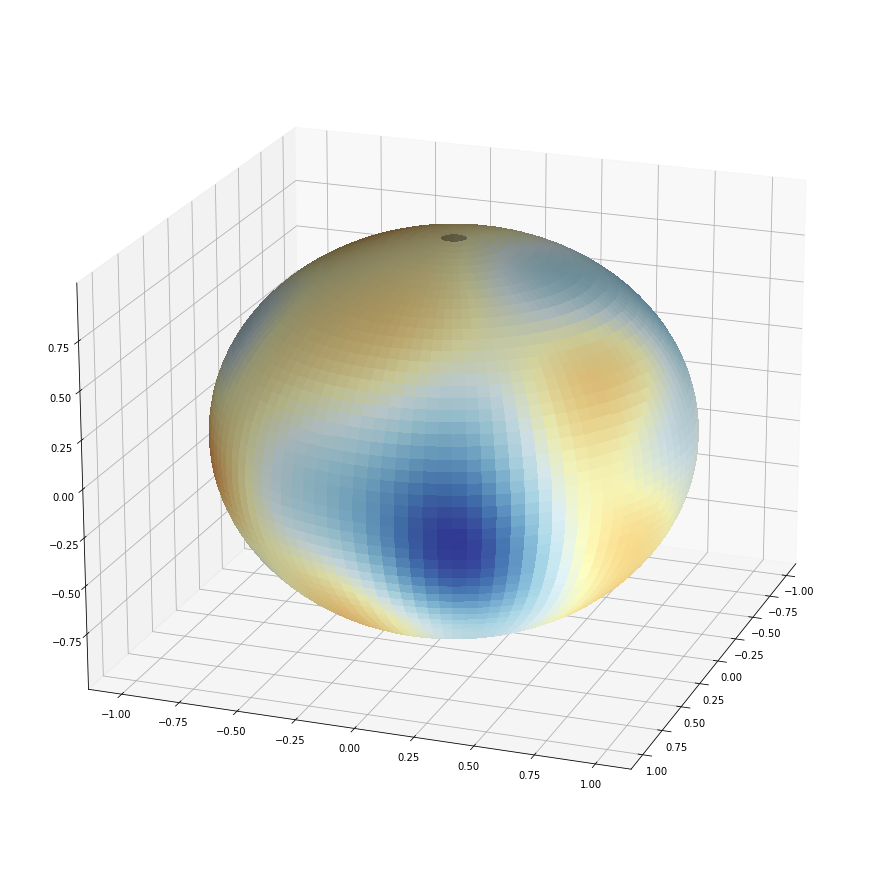

In [8]:
from matplotlib import colors, cm
grid.sphere_plot(grfs[0],cmap=cm.RdYlBu);